In [1]:
import math
import random
import time
from jupyterthemes import jtplot
from tqdm import tqdm_notebook as tqdm

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline
gym.logger.set_level(40)
jtplot.style()
torch.backends.cudnn.benchmark = True

use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

from common.common_sac import NormalizedActions, ReplayBuffer, ValueNetwork, SoftQNetwork, PolicyNetwork

In [2]:
normalize = True
env_name = "Pusher-v2"
#env_name = "BipedalWalker-v2"
#env = gym.make(env_name)

if normalize:
    env = NormalizedActions(gym.make(env_name))

else:
    env = gym.make(env_name)
#env = NormalizedActions(gym.make(env_name))


num_inputs  = env.observation_space.shape[0]
state_dim  = env.observation_space.shape[0]
num_outputs = env.action_space.shape[0]
action_dim = env.action_space.shape[0]

if env_name == "BipedalWalker-v2":
    num_steps = 2000
    expert_traj = np.load("trajectory/BipedalWalker_100.npy")
    min_buffer_size      = 4000
    batch_size           = 500

if env_name == "Pendulum-v0":
    num_steps = 200
    expert_traj = np.load("trajectory/Pendulum_SAC_50000_-153.npy")
    min_buffer_size      = 1000
    batch_size           = 256

if env_name == "Pusher-v2":
    num_steps = 100
    expert_traj = np.load("trajectory/Pusher-v2_PPO_-32.npy")
    min_buffer_size      = 1000
    batch_size           = 256
    
#Hyper params:
hidden_dim           = 128
#a2c_hidden_size      = 128
discrim_hidden_size  = 128
lr                   = 3e-4
num_G_updates        = 5
num_D_updates        = 1

print("Normalize:",normalize)
print("states,actions:",num_inputs,num_outputs)

Normalize: True
states,actions: 23 7


In [3]:
def soft_q_update(batch_size, 
           gamma=0.99,
           mean_lambda=1e-3,
           std_lambda=1e-3,
           z_lambda=0.0,
           soft_tau=0.1,
          ):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    
    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)
    
    #最新の報酬を利用
#    print(reward.shape)
    reward = expert_reward(state, action)
    reward = torch.FloatTensor(reward).to(device)
    
    expected_q_value = soft_q_net(state, action)
    expected_value   = value_net(state)
    new_action, log_prob, z, mean, log_std = policy_net.evaluate(state)


    target_value = target_value_net(next_state)
    next_q_value = reward + (1 - done) * gamma * target_value
    q_value_loss = soft_q_criterion(expected_q_value, next_q_value.detach())

    expected_new_q_value = soft_q_net(state, new_action)
    next_value = expected_new_q_value - log_prob
    value_loss = value_criterion(expected_value, next_value.detach())

    log_prob_target = expected_new_q_value - expected_value
    policy_loss = (log_prob * (log_prob - log_prob_target).detach()).mean()
    

    mean_loss = mean_lambda * mean.pow(2).mean()
    std_loss  = std_lambda  * log_std.pow(2).mean()
    z_loss    = z_lambda    * z.pow(2).sum(1).mean()

    policy_loss += mean_loss + std_loss + z_loss

    soft_q_optimizer.zero_grad()
    q_value_loss.backward()
    soft_q_optimizer.step()

    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()

    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()
    
    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - soft_tau) + param.data * soft_tau
        )

In [4]:
class Discriminator(nn.Module):
    def __init__(self, num_inputs, hidden_size):
        super(Discriminator, self).__init__()
        
        self.linear1   = nn.Linear(num_inputs, hidden_size)
        self.linear2   = nn.Linear(hidden_size, hidden_size)
        self.linear3   = nn.Linear(hidden_size, 1)
        self.linear3.weight.data.mul_(0.1)
        self.linear3.bias.data.mul_(0.0)
    
    def forward(self, x):
        x = F.tanh(self.linear1(x))
        x = F.tanh(self.linear2(x))
        prob = F.sigmoid(self.linear3(x))
        return prob
    
def expert_reward(state, action):
    state_action = torch.cat((state,action),1)
    # return -np.log(1-discriminator(state_action).cpu().data.numpy())
#    return np.log(discriminator(state_action).cpu().data.numpy())
    return np.log(discriminator(state_action).cpu().data.numpy()) - np.log(1-discriminator(state_action).cpu().data.numpy())

In [5]:
def plot(frame_idx, rewards, D_fake, D_real):
    clear_output(True)
    plt.figure(figsize=(20,8))
    plt.subplot(121)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.subplot(122)
    plt.title('Agent(fake) %s  Expert(real) %s' % (D_fake[-1] ,D_real[-1]))
    plt.plot(D_fake)
    plt.plot(D_real)
#    plt.subplot(223)
#    plt.title('loss %s' % (losses[-1:]))
#    plt.plot(losses)
    plt.show()
    
def test_env(vis=False):
    state = env.reset()
    if vis: env.render()
    done = False
    total_reward = 0
    while not done:
        action = policy_net.get_action(state)
#        next_state, reward, done, _ = env.step(dist.mean.detach().cpu().numpy()[0])
        next_state, reward, done, _ = env.step(action)
        state = next_state
        time.sleep(0.01)
#        print(reward)
        if vis: env.render()
        total_reward += reward
    return total_reward

In [6]:
def discriminator_update():
    expert_state_action = expert_traj[np.random.randint(0, expert_traj.shape[0], states.shape[0]), :]
    expert_state_action = torch.FloatTensor(expert_state_action).to(device)
    fake = discriminator(state_actions)
    real = discriminator(expert_state_action)

#軌道がエージェント軌道である確率　agentを1 expertを0にする　エージェント的には高いほうがいいlogDの最大化
#    discrim_loss = discrim_criterion(fake, torch.ones((states.shape[0], 1)).to(device)) + \
#            discrim_criterion(real, torch.zeros((expert_state_action.size(0), 1)).to(device))
    discrim_loss = discrim_criterion(real, torch.ones((expert_state_action.size(0), 1)).to(device)) + \
            discrim_criterion(fake, torch.zeros((states.shape[0], 1)).to(device))

    optimizer_discrim.zero_grad()
    discrim_loss.backward()
    optimizer_discrim.step()
    return real,fake

In [7]:
value_net        = ValueNetwork(state_dim, hidden_dim).to(device)
target_value_net = ValueNetwork(state_dim, hidden_dim).to(device)

soft_q_net = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)
    
value_criterion  = nn.MSELoss()
soft_q_criterion = nn.MSELoss()

value_lr  = 3e-4
soft_q_lr = 3e-4
policy_lr = 3e-4

value_optimizer  = optim.Adam(value_net.parameters(), lr=value_lr)
soft_q_optimizer = optim.Adam(soft_q_net.parameters(), lr=soft_q_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)


replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)

#-----------------------------------------------------------------------------

discriminator = Discriminator(num_inputs + num_outputs, discrim_hidden_size).to(device)
discrim_criterion = nn.BCELoss()
optimizer_discrim = optim.Adam(discriminator.parameters(), lr=lr)

In [8]:
test_rewards = []
D_real    = []
D_fake    = []
max_frames = 50000000000
frame_idx = 0
done = False

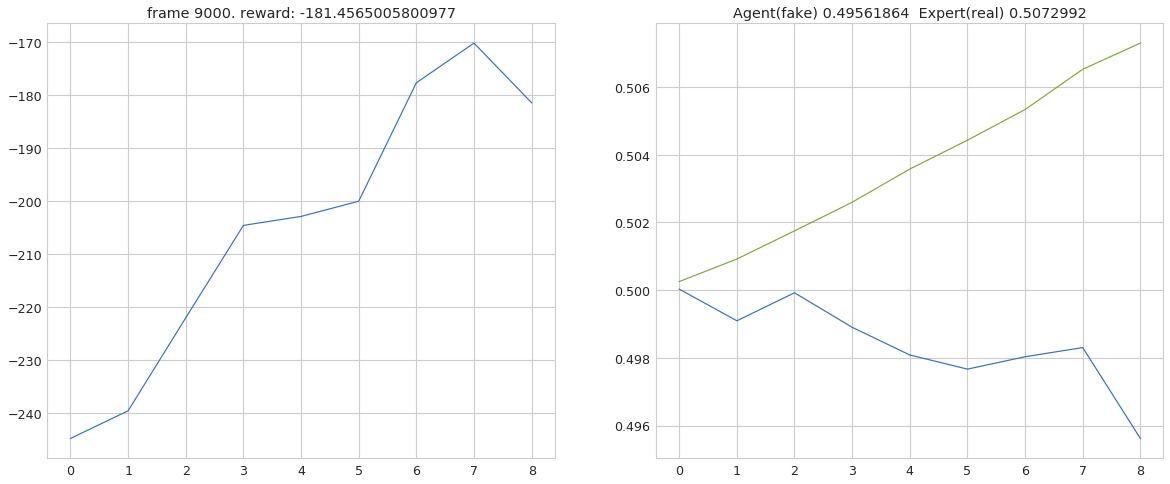


10000


In [ ]:
# 最大フレームまでエポックループ
while frame_idx < max_frames:
    log_probs = []
    values    = []
    states    = []
    actions   = []
    rewards   = []
    masks     = []
    returns   = []

    # 更新バッファサイズまでエピソードループ
    while len(states) < min_buffer_size:
        state = env.reset()
        rewards_ = []
        masks_ = []
        values_ = []
        
        # エピソード終了までタイムステップループ
        for i in tqdm(range(1, num_steps+1)):
            action = policy_net.get_action(state)
            next_state, reward, done, _ = env.step(action)
            
            
            
            
            
            
            
            
            
            
            
            
            state_tensor = torch.FloatTensor(np.reshape(state, (1,-1))).to(device)
            action_tensor = torch.FloatTensor(np.reshape(action, (1,-1))).to(device)
            exp_reward = expert_reward(state_tensor, action_tensor)
            exp_reward = np.reshape(exp_reward, (-1,))
            
            replay_buffer.push(state, action, exp_reward, next_state, done)
            if len(replay_buffer) > batch_size:
                soft_q_update(batch_size)
            if i == num_steps:
                done == True

            # log
            states.append(state_tensor)
            actions.append(action_tensor)            

            state = next_state
            frame_idx += 1
            
            if done:
                break   

        # エピソード終了後
#        print("done time:", i, "episode reward:")
        next_state = torch.FloatTensor(next_state).to(device)
    print(frame_idx)
    states    = torch.cat(states).to(device)
    actions   = torch.cat(actions).to(device)

    # Discriminator
    state_actions = torch.cat([states, actions], 1)
    for _ in range(num_D_updates):
        real, fake = discriminator_update()


    # Test
    test_reward = np.mean([test_env() for _ in range(3)])
    test_rewards.append(test_reward)
    D_real.append(torch.mean(real).data.cpu().numpy())
    D_fake.append(torch.mean(fake).data.cpu().numpy())
    plot(frame_idx, test_rewards, D_fake, D_real)

In [ ]:
test_env(True)

In [ ]:
# model save

MODEL_PATH_ACTOR = 'asset/GAIL/GAIL_actor.pth'
MODEL_PATH_CRITIC = 'asset/GAIL/GAIL_critic.pth'
MODEL_PATH_DISCRIMINATOR = 'asset/GAIL/GAIL_discriminator.pth'

torch.save(actor.state_dict(), MODEL_PATH_ACTOR)
torch.save(critic.state_dict(), MODEL_PATH_CRITIC)
torch.save(discriminator.state_dict(), MODEL_PATH_DISCRIMINATOR)


In [ ]:
200 256 収束120ステップ